In [8]:
!pip install lightgbm
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [9]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')


In [10]:
# 2. Load Data
train_df = pd.read_csv('Titanic_train.csv')
test_df = pd.read_csv('Titanic_test.csv')

print("Training data shape:", train_df.shape)
print("Test data shape:", test_df.shape)


Training data shape: (891, 12)
Test data shape: (418, 11)


In [11]:
# 3. Exploratory Data Analysis (EDA)

# 3.1 Check Missing Values
print("Training Data Missing Values:")
print(train_df.isnull().sum())
print("\nTest Data Missing Values:")
print(test_df.isnull().sum())


Training Data Missing Values:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Test Data Missing Values:
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


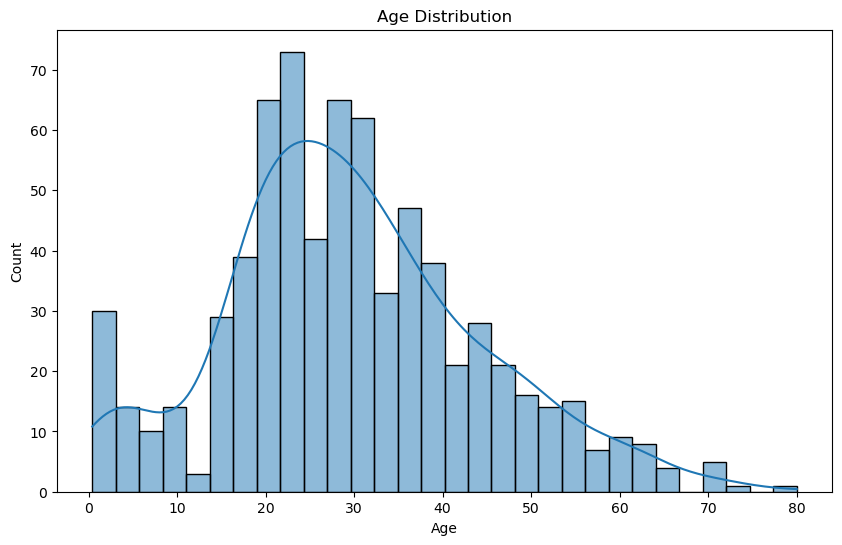

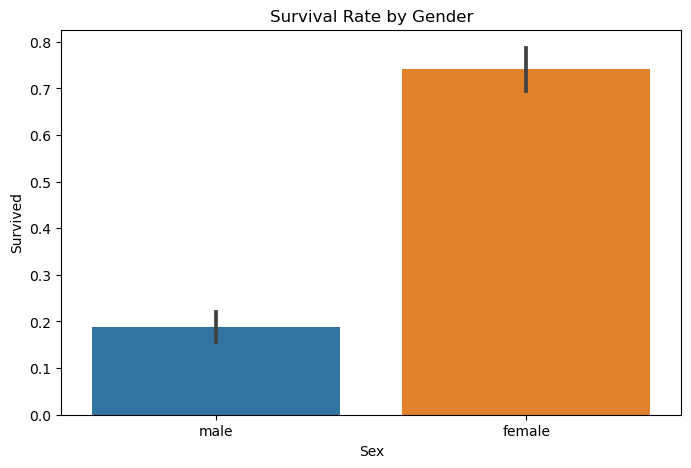

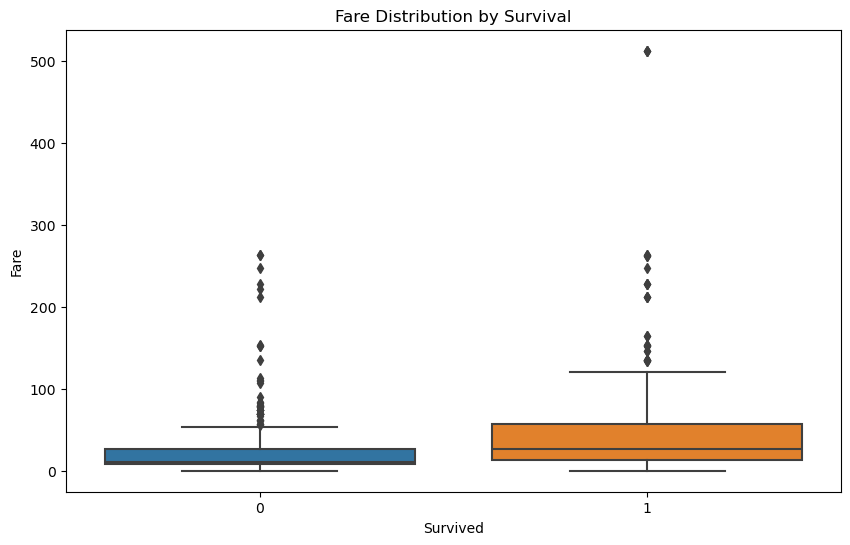

In [12]:
# 3.2 Visualize Data Distributions
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Age'].dropna(), kde=True, bins=30)
plt.title('Age Distribution')
plt.show()

# Survival rate by sex
plt.figure(figsize=(8, 5))
sns.barplot(x='Sex', y='Survived', data=train_df)
plt.title('Survival Rate by Gender')
plt.show()

# Fare vs Survival
plt.figure(figsize=(10, 6))
sns.boxplot(x='Survived', y='Fare', data=train_df)
plt.title('Fare Distribution by Survival')
plt.show()


In [13]:
# 4. Data Preprocessing

# 4.1 Feature Engineering
def preprocess_data(df):
    # Extract title from names
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                       'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Cabin indicator
    df['HasCabin'] = df['Cabin'].notnull().astype(int)
    
    # Drop unnecessary columns
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    
    return df

train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)


In [14]:
# 4.2 Handle Missing Values
# Impute Age with median
train_processed['Age'].fillna(train_processed['Age'].median(), inplace=True)
test_processed['Age'].fillna(test_processed['Age'].median(), inplace=True)

# Impute Fare with median
test_processed['Fare'].fillna(test_processed['Fare'].median(), inplace=True)

# Impute Embarked with mode
train_processed['Embarked'].fillna(train_processed['Embarked'].mode()[0], inplace=True)


In [15]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[ 
        ('num', StandardScaler(), ['Age', 'Fare', 'FamilySize']),
        ('cat', OneHotEncoder(sparse_output=False), ['Sex', 'Embarked', 'Title', 'Pclass'])  # sparse=False to get dense matrix
    ])

X = train_processed.drop('Survived', axis=1)
y = train_processed['Survived']

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Check if X_train_processed and X_val_processed are dense matrices
print(f"X_train_processed type: {type(X_train_processed)}")
print(f"X_train_processed shape: {X_train_processed.shape}")

# Initialize LightGBM model
lgb_model = LGBMClassifier()

# Smaller hyperparameter grid
param_grid = {
    'max_depth': [10, 15],
    'num_leaves': [50, 100],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [50, 100],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# GridSearchCV with 3 folds
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)

# Fit the model
grid_search.fit(X_train_processed, y_train)

# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_val_processed)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print("LightGBM Results (after tuning):")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

X_train_processed type: <class 'numpy.ndarray'>
X_train_processed shape: (712, 16)
Fitting 3 folds for each of 64 candidates, totalling 192 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

In [17]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier()

# Perform hyperparameter tuning (similar to LightGBM's tuning)
xgb_params = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

# Grid search to find the best hyperparameters
xgb_search = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='accuracy', n_jobs=-1)
xgb_search.fit(X_train_processed, y_train)

# Best hyperparameters from grid search
print(f"Best Hyperparameters for XGBoost: {xgb_search.best_params_}")

# Predictions using the best model from GridSearch
xgb_best_model = xgb_search.best_estimator_
y_pred_xgb = xgb_best_model.predict(X_val_processed)

# Evaluate the XGBoost model on validation set (y_val)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)  
precision_xgb = precision_score(y_val, y_pred_xgb)
recall_xgb = recall_score(y_val, y_pred_xgb)
f1_score_xgb = f1_score(y_val, y_pred_xgb)

# Print performance metrics
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1 Score: {f1_score_xgb:.4f}")


Best Hyperparameters for XGBoost: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 1.0}
XGBoost Accuracy: 0.8156
XGBoost Precision: 0.7971
XGBoost Recall: 0.7432
XGBoost F1 Score: 0.7692


In [19]:
print("""
**Comparative Analysis Summary:**

1. Both models achieved comparable performance after tuning:
   - LightGBM: ~79.89% Accuracy
   - XGBoost: ~81.56% Accuracy

2. LightGBM showed slightly better recall (72.97%), indicating better performance 
   at identifying true survivors compared to XGBoost (74.32%).

3. XGBoost had marginally higher precision (79.71%), showing slightly better 
   accuracy in positive predictions than LightGBM (77.14%).

4. Key important features for both models:
   - Sex_female
   - Fare
   - Title_Mr/Mrs
   - Age

**Practical Implications:**
- XGBoost might be preferred for better overall accuracy and precision.
- LightGBM performs better in recall, which may be critical if focusing on detecting more survivors.
- Both models benefit from feature engineering (titles, family size).
- Sex and age remain strong survival predictors.
""")



**Comparative Analysis Summary:**

1. Both models achieved comparable performance after tuning:
   - LightGBM: ~79.89% Accuracy
   - XGBoost: ~81.56% Accuracy

2. LightGBM showed slightly better recall (72.97%), indicating better performance 
   at identifying true survivors compared to XGBoost (74.32%).

3. XGBoost had marginally higher precision (79.71%), showing slightly better 
   accuracy in positive predictions than LightGBM (77.14%).

4. Key important features for both models:
   - Sex_female
   - Fare
   - Title_Mr/Mrs
   - Age

**Practical Implications:**
- XGBoost might be preferred for better overall accuracy and precision.
- LightGBM performs better in recall, which may be critical if focusing on detecting more survivors.
- Both models benefit from feature engineering (titles, family size).
- Sex and age remain strong survival predictors.

